<img src="images/00-image.png" alt="encoder" class="bg-primary" width="100%">


 [Image Reference](https://www.planetware.com/tourist-attractions-/potsdam-d-br-pt.htm)

<h1><center> Vision Transformer <center></h1>

Vision Transformer (ViT) paper: [Paper Reference](https://arxiv.org/abs/2010.11929)

-------

In [1]:
import numpy as np

In [2]:
import os
import pandas as pd

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchinfo import summary
import torchvision
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from torchvision import datasets, transforms
from mlxtend.plotting import plot_confusion_matrix

import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
from numpy import expand_dims, moveaxis
from numpy import asarray
from PIL import Image

In [6]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.0
torchvision version: 0.18.0


In [7]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Vision Transformer Introduction

### ViT Architecture : Figure 1

<img src="images/01-vitpaper.png" alt="encoder" class="bg-primary" width="60%">


Component ViT Architecture:
* **Inputs** - What goes into the model? (image sequence as tensors)
* **Outputs** - What comes out of the model/layer/block? (image classification labels)
* **Layers** - Takes an input, manipulates it with a function (E.g : self-attention)
* **Blocks** - Collection of layers
* **Model** - Collection of blocks

Embedding are learnable representation (we start with random numbers and it improve over time) 

#

### Four equations introduction
<img src="images/03-vitpaper_4equations.png" alt="encoder" class="bg-primary" width="60%">

* Four equations: Equations that explain the Model architecture

#

### Different Sizes of Architecture based on Hyper-parameters

<img src="images/02-vitpaper_table.png" alt="encoder" class="bg-primary" width="60%">

* ViT-Base, ViT-Large and ViT-Huge represent different model sizes
* ViT-B/16 = ViT-Base with image patch size 16x16 will be implemented
* Layers - the number of transformer encoder layers 
* Hidden size $D$ - the embedding size / latent space dimension
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention 

#

### 1.1 Visualize a single image

In [8]:
img_size = 224
data_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                     transforms.ToTensor()])

# Example usage
img = Image.open('images/test_image.jpg')
image = data_transform(img)

Image shape: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'Cat')

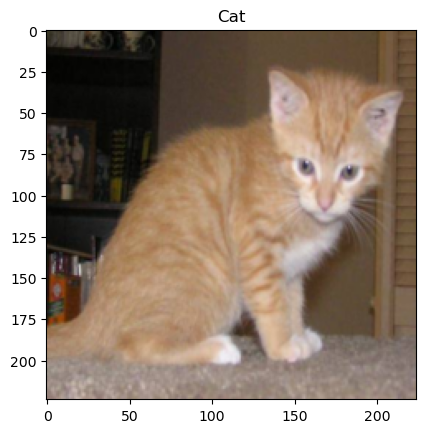

In [9]:
label = ['Cat']
print(f"Image shape: {image.shape}")
plt.imshow(np.transpose(image, (1, 2, 0))) # image shape is [3, 224,224] (colour channels, height, width)
plt.title(label[0])

In [10]:
image

tensor([[[0.2510, 0.2275, 0.2275,  ..., 0.4157, 0.4078, 0.4078],
         [0.2549, 0.2314, 0.2235,  ..., 0.4235, 0.4118, 0.4118],
         [0.2510, 0.2275, 0.2118,  ..., 0.4196, 0.4196, 0.4196],
         ...,
         [0.6118, 0.5804, 0.5843,  ..., 0.6471, 0.6392, 0.6235],
         [0.5843, 0.5686, 0.5725,  ..., 0.6275, 0.6196, 0.6118],
         [0.6039, 0.5843, 0.5843,  ..., 0.5961, 0.6000, 0.6039]],

        [[0.2392, 0.2157, 0.2157,  ..., 0.3176, 0.3098, 0.3098],
         [0.2431, 0.2196, 0.2118,  ..., 0.3255, 0.3137, 0.3137],
         [0.2392, 0.2157, 0.2000,  ..., 0.3216, 0.3216, 0.3216],
         ...,
         [0.5333, 0.5020, 0.5059,  ..., 0.5725, 0.5686, 0.5529],
         [0.4980, 0.4824, 0.4863,  ..., 0.5529, 0.5529, 0.5451],
         [0.5137, 0.4941, 0.4941,  ..., 0.5255, 0.5333, 0.5373]],

        [[0.1647, 0.1412, 0.1490,  ..., 0.2000, 0.1922, 0.1922],
         [0.1686, 0.1490, 0.1490,  ..., 0.2078, 0.1961, 0.1961],
         [0.1725, 0.1490, 0.1412,  ..., 0.2039, 0.2039, 0.

#

## 2. Implementation of the four major equations 

### Four equations

<img src="images/03-vitpaper_4equations.png" alt="encoder" class="bg-primary" width="60%">

### 2.1 Equation 1: Split data into patches and creating the class, position and patch embedding

> **Equation 1:**
Transformer requires as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches. The Transformer uses constant latent vector size $D$ through all of its layers. Thus we create latent space of $D$ dimensions with a trainable linear projection.
- Class token is prepended to the patch embedding, increasing the dimension to $N + 1$
- Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings.


* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right)}$
* P = patch size
* N = number of patches = $(H * W) / P^{2}$
* D = constant latent vector size = embedding dimension

In [11]:
height = 224
width = 224
color_channels = 3
patch_size = 16 

# Required number of patches
no_required_patches = int((height * width) / patch_size**2)
no_required_patches

196

In [12]:
# Embedding input shape
input_shape = (height, width, color_channels)

# Embedding output shape
output_shape = (no_required_patches, patch_size**2 * color_channels)

print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape} -> (number_of_patches, embedding_dimension)")

Input shape: (224, 224, 3)
Output shape: (196, 768) -> (number_of_patches, embedding_dimension)


#### 2.1.1 Visualizing image as patches

Image shape: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'Cat')

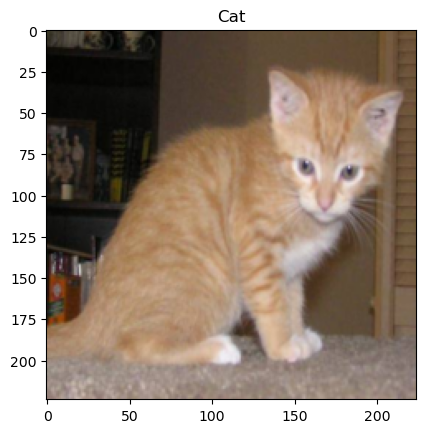

In [13]:
img = Image.open('images/test_image.jpg')
image = data_transform(img)

label = ['Cat']
print(f"Image shape: {image.shape}")
plt.imshow(np.transpose(image, (1, 2, 0))) # image shape is [3, 224,224] (colour channels, height, width)
plt.title(label[0])

Expected number of patches: 14


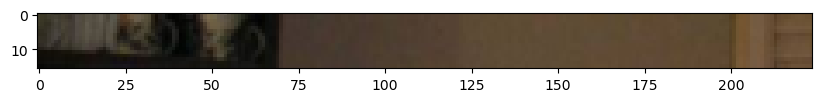

In [14]:
image_permuted = image.permute(1, 2, 0) # convert image to (H, W, C) dimension


patch_size = 16

# Image size must be divisible by patchsize
print(f'Expected number of patches: {int(224/16)}') 

plt.figure(figsize=(10,10))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14
Each patch size: 16 pixels x 16 pixels


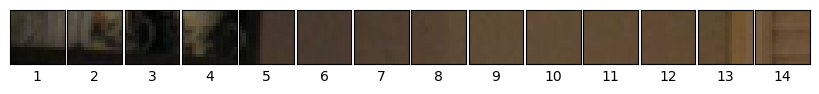

In [15]:
# Visualizing slice of patches
img_size = 224
patch_size = 16
num_patches = int(img_size/patch_size)

print(f"Number of patches per row: {num_patches}\nEach patch size: {patch_size} pixels x {patch_size} pixels")


# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols= img_size // patch_size, # Image size must be divisible by patchsize
                        sharex=True,
                        sharey=True,
                        figsize=(10,10))


fig.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.05, hspace=0.05)
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); 
    axs[i].set_xlabel(i+1) # set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Total patches: 196 
Each patch size: 16 pixels x 16 pixels


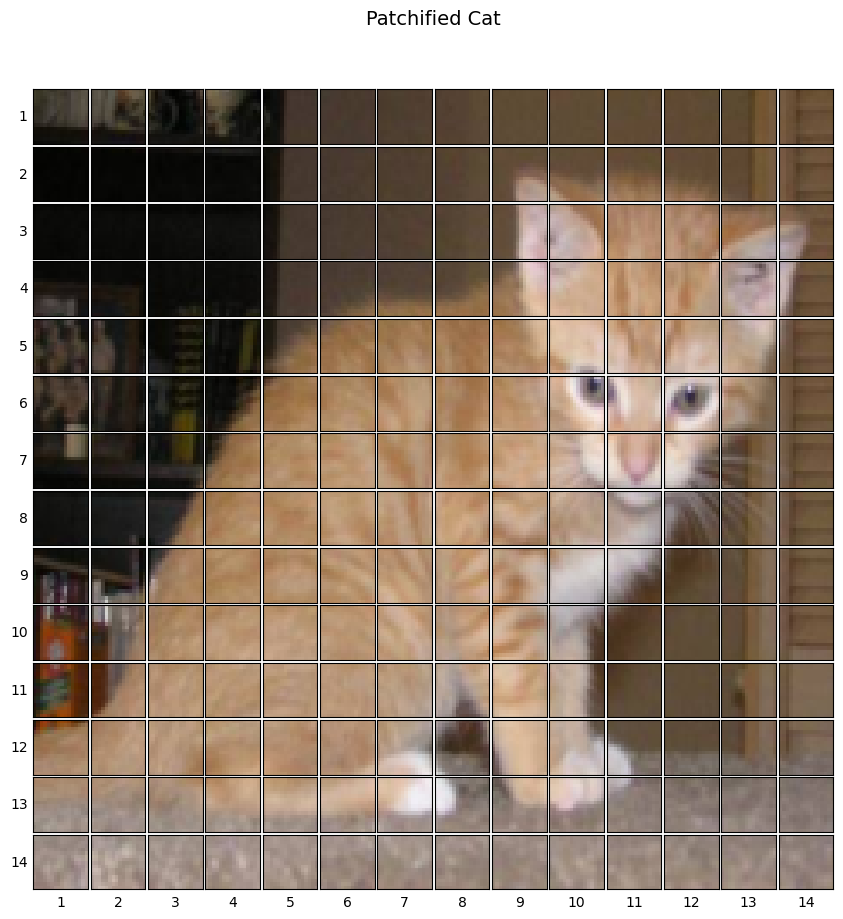

In [16]:
# Visualizing all patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
print(f"Total patches: {int(num_patches*num_patches)} \nEach patch size: {patch_size} pixels x {patch_size} pixels")


fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(10,10),
                        sharex=True,
                        sharey=True)

fig.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.05, hspace=0.05)

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):

        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,  patch_width:patch_width+patch_size, :])
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment="right", verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
fig.suptitle(f"Patchified {label[0]}", fontsize=14)
plt.show()

#### 2.1.2 Creating patch embeddings

We can create the same patches using `torch.nn.Conv2d()`, setting the kernel size and stride parameters to `patch_size`. 

In [17]:
patch_size = 16
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, # hidden size D from Table 1 for ViT-Base
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

Image shape: torch.Size([3, 224, 224])


Text(0.5, 1.0, 'Cat')

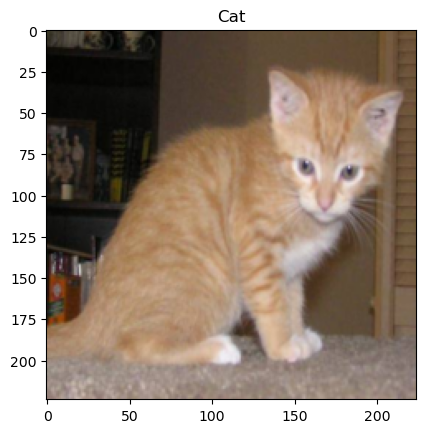

In [18]:
img = Image.open('images/test_image.jpg')
image = data_transform(img)

label = ['Cat']
print(f"Image shape: {image.shape}")
plt.imshow(np.transpose(image, (1, 2, 0))) # image shape is [3, 224,224] (colour channels, height, width)
plt.title(label[0])

In [19]:
# Generate an example
conv2d_image = conv2d(image.unsqueeze(0)) # add batch dimension -> (batch_size, 786 (neuron), color_channels, height, width)
print(conv2d_image.shape) 

torch.Size([1, 768, 14, 14])


In [20]:
#conv2d_image.requires_grad

Now we've passed a single image to our `conv2d` layer, it's shape becomes: 

```python
torch.Size([1, 768, 14, 14]) # [batch_size, embedding_dim, feature_image_height, feature_image_width] 
```

Showing few feature maps using random indexes: [529, 363, 605, 98, 251, 407, 39, 231]


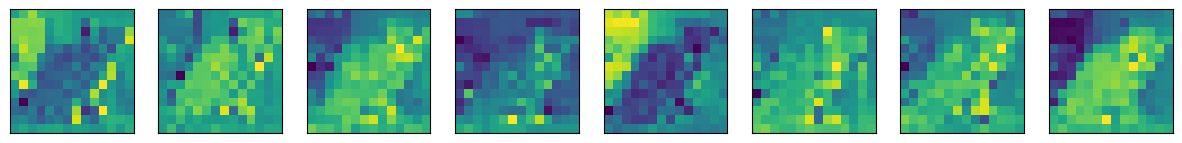

In [21]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0, 758), k=8)
print(f"Showing few feature maps using random indexes: {random_indexes}")

# Create plot 
fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(15, 15))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = conv2d_image[:, idx, :, :] # index on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension, and remove from grad tracking/switch to numpy for matplotlib
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [22]:
# Get a single feature map in tensor form
single_feature_map = conv2d_image[:, 0, :, :] 
single_feature_map, single_feature_map.requires_grad

(tensor([[[-1.8997e-03, -6.4120e-02,  4.4714e-02, -1.1708e-01,  2.8149e-02,
           -2.0829e-02, -1.9370e-02, -2.1272e-02, -2.8930e-02, -2.5375e-02,
           -2.1899e-02, -2.5724e-02, -1.4777e-02, -3.1426e-02],
          [ 3.1991e-02,  3.0600e-02,  2.3616e-02,  9.4067e-03, -4.0956e-05,
           -1.6800e-02, -2.2842e-02, -2.7126e-02, -3.2116e-02, -4.1345e-02,
           -4.3405e-02, -2.4616e-02, -1.9711e-02, -8.4062e-03],
          [ 2.8404e-02,  2.7475e-02,  3.2179e-02,  3.4747e-02, -4.8203e-03,
           -1.7055e-02, -2.2618e-02, -1.9111e-02,  7.8571e-02, -1.7249e-01,
           -7.5787e-02, -9.6895e-02, -4.3569e-02, -5.2540e-02],
          [ 7.3301e-02,  2.4994e-02,  3.1078e-02,  1.5211e-02, -1.7474e-02,
           -1.5956e-02, -9.9574e-03,  3.2278e-03,  3.1044e-02, -1.1876e-01,
           -9.8340e-02, -1.9728e-02, -6.2828e-02, -3.2612e-02],
          [-1.6191e-02, -1.0702e-02,  2.2904e-02,  3.4994e-02,  2.3189e-03,
           -2.6895e-02, -4.9366e-02, -6.8079e-02, -1.1088e-0

#### 2.1.3 Flattening the patch embedding with `torch.nn.Flatten()`

- Converting each feature maps into a sequence of patch embeddings using flatten to satisfy the input criteria of the ViT Transformer Encoder.

In [23]:
print(f"{conv2d_image.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")

torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Want: (batch_size, number_of_patches, embedding_dim)

In [24]:
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

flatten_layer(conv2d_image).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


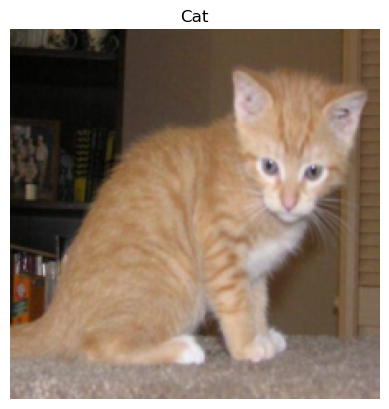

In [25]:
# In general: patch embedding
plt.imshow(image.permute(1, 2, 0))
plt.title(label[0])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
conv2d_image = conv2d(image.unsqueeze(0)) # add batch dimension
print(f"Image feature map (patches) shape: {conv2d_image.shape}")

# Flatten the feature maps
conv2d_image_flattened = flatten_layer(conv2d_image)
print(f"Flattened image feature map shape: {conv2d_image_flattened.shape}")

In [26]:
# Rearrange output of flattened layer
conv2d_image_flattened_permuted = conv2d_image_flattened.permute(0, 2, 1)
print(f"{conv2d_image_flattened_permuted.shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([1, 196, 768]) -> (batch_size, number_of_patches, embedding_dimension)


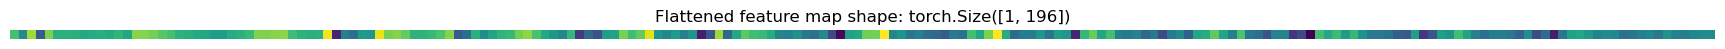

In [27]:
# Get a single flattened feature map
single_flattened_feature_map = conv2d_image_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False); 

#### 2.1.4 Creating a patch embedding layer block

In [28]:
class Patch_Embeddings(nn.Module):

    def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768): # from Table 1 for ViT-Base
        super().__init__()

        self.patch_size = patch_size


        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)

    def forward(self, x):

        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        patched_img = self.patcher(x) 
        flattened_img = self.flatten(patched_img)
        
        return flattened_img.permute(0, 2, 1)

In [29]:
# An example
patchify = Patch_Embeddings(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through patch embedding layer
print(f"Input image size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f"Output patch embedding sequence shape: {patch_embedded_image.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


* **Input:** The image starts as 2D with size ${H \times W \times C}$.
* **Output:** The image gets converted to a 1D sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [30]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

patchify(rand_image_tensor)

tensor([[[-0.1441, -0.0585,  0.1870,  ..., -0.2428, -0.1880, -0.2268],
         [ 0.2773,  0.7267,  1.0925,  ..., -0.4989,  0.2769, -0.9633],
         [-1.5950,  0.1940, -0.4490,  ...,  0.0650,  0.4761,  0.6227],
         ...,
         [ 0.0244,  0.4377,  0.6785,  ..., -0.5910,  0.2171,  0.6493],
         [ 0.2117,  0.7446, -0.2950,  ..., -0.5661, -0.3479, -0.0229],
         [ 0.0387, -0.1083, -1.7661,  ...,  0.5016,  0.8920, -0.2102]]],
       grad_fn=<PermuteBackward0>)

#

#### 2.1.5 Creating the class token embedding

Want to: prepend a learnable class token to the start of the patch embedding.

In [31]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [32]:
# Create class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [33]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [34]:
# Prepend a class token embedding to the patch embedding 
patch_and_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

print(patch_and_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_and_class_embedding.shape} -> (batch_size, class_token + number_of_patches, embedding_dim)")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.2037, -0.0649,  0.0379,  ...,  0.0563, -0.2172, -0.0086],
         [ 0.1291, -0.1012,  0.0143,  ...,  0.0904, -0.2851,  0.0020],
         ...,
         [ 0.1070, -0.4973,  0.0558,  ...,  0.1225, -0.6419, -0.1511],
         [ 0.1300, -0.4851,  0.0656,  ...,  0.1207, -0.6351, -0.1641],
         [ 0.1192, -0.4785,  0.0373,  ...,  0.1351, -0.6370, -0.1379]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dim)


#

#### 2.1.6 Creating the position embedding

- Create a series of 1D learnable position embeddings, add to patch embeddings to preserve the positional inofrmation.

In [35]:
# Calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the embedding dimension
embedding_dimension = patch_and_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, # to account for additional token (class token)
                                             embedding_dimension),
                                  requires_grad=True)

In [36]:
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [37]:
patch_and_class_embedding, patch_and_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.2037, -0.0649,  0.0379,  ...,  0.0563, -0.2172, -0.0086],
          [ 0.1291, -0.1012,  0.0143,  ...,  0.0904, -0.2851,  0.0020],
          ...,
          [ 0.1070, -0.4973,  0.0558,  ...,  0.1225, -0.6419, -0.1511],
          [ 0.1300, -0.4851,  0.0656,  ...,  0.1207, -0.6351, -0.1641],
          [ 0.1192, -0.4785,  0.0373,  ...,  0.1351, -0.6370, -0.1379]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [38]:
# Add the position embedding to the patch and class token embedding
full_embedding = patch_and_class_embedding + position_embedding
print(full_embedding)
print(f"Full embedding shape: {full_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.2037, 0.9351, 1.0379,  ..., 1.0563, 0.7828, 0.9914],
         [1.1291, 0.8988, 1.0143,  ..., 1.0904, 0.7149, 1.0020],
         ...,
         [1.1070, 0.5027, 1.0558,  ..., 1.1225, 0.3581, 0.8489],
         [1.1300, 0.5149, 1.0656,  ..., 1.1207, 0.3649, 0.8359],
         [1.1192, 0.5215, 1.0373,  ..., 1.1351, 0.3630, 0.8621]]],
       grad_fn=<AddBackward0>)
Full embedding shape: torch.Size([1, 197, 768])


#### 2.1.7 Putting it all together: from image to embedding

We've written code to turn an image into a flattened sequence of patch embeddings.

Now let's it all in one cell.

In [39]:
# In general: Full embedding
# 1. Set the patch size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = Patch_Embeddings(in_channels=3,
                                         patch_size=patch_size, 
                                         embedding_dim=768)

# 5. Pass input image through Patch_Embeddings
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Add the position embedding to patch embedding with class token
full_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {full_embedding.shape} ")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768]) 


#

### 2.2 Equation 2: Multihead Self-Attention (MSA block)

**Equations 2:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A)

*Self Attention* $Y=\underbrace{\operatorname{softmax}\left(Q K^{\top}\right)}_{\text {Attention matrix } A} V$


*Scale Factor*  = $\frac{1}{\sqrt{D_{\text {model }}}}$

* **Multihead self-attention** = which part of a sequence should pay the most attention to itself?
  *  Multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image.


* **LayerNorm** = Layer normalization (LayerNorm) is a technique to normalize the distributions of intermediate layers. It enables smoother gradients, faster training, and better generalization accuracy.
  * Normalization = make everything have the same mean and same standard deviation.

In [44]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, embed_dim, head_size, dropout):
        super().__init__()
        self.key = nn.Linear(embed_dim, head_size)
        self.query = nn.Linear(embed_dim, head_size)
        self.value = nn.Linear(embed_dim, head_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        # input of size (batch, latent-space, feature map)
        # output of size (batch, latent-space, head size)
        
        B,T,C = key.shape
        
        key = self.key(key)   # (B,T,hs)
        query = self.query(query) # (B,T,hs)
        
        # compute attention scores ("affinities")
        matmul_qk = query @ key.transpose(-2,-1) # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        
        scores = matmul_qk * key.shape[-1]**-0.5 # Scale Factor

        #scores = scores.masked_fill(torch.tril(torch.ones(T,T)) == 0, float('-inf'))# (B, T, T)
        
        p_attn = F.softmax(scores, dim=-1) # (B, T, T)
        
        p_attn = self.dropout(p_attn)
        
        # perform the weighted aggregation of the values
        value = self.value(value) # (B,T,hs)
        attention = p_attn @ value # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        
        return attention

In [45]:
class MultiHeadAttention(nn.Module):
    """ 
    multiple heads of self-attention in parallel
    
    """

    def __init__(self, embed_dim, num_heads, dropout):
        super().__init__()
        
        head_size = embed_dim // num_heads
        
        self.heads = nn.ModuleList([Head(embed_dim, head_size, dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        attention = torch.cat([h(query, key, value) for h in self.heads], dim=-1)
        
        attention = self.dropout(self.proj(attention))
        
        return attention

In [46]:
class MSAttention_Block(nn.Module): 
    """Creates a multi-head self-attention block
    """
    def __init__(self, embedding_dim:int=768, num_heads:int=12, attn_dropout:float=0): # Heads from Table 1 for ViT-Base
        super().__init__()
        
        # Layer Norm (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Multihead attention (MSA) layer
        self.multihead_attn = MultiHeadAttention(embed_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 dropout=attn_dropout)

    
    def forward(self, x):
        x = self.layer_norm(x)
        
        attention = self.multihead_attn(query=x,
                                          key=x,
                                          value=x)
        
        return attention

###

In [47]:
# Create an instance MSA block
multihead_self_attention_block = MSAttention_Block(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# Pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(full_embedding)
print(f"Input shape of MSA block: {full_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


#

#

### 2.3 Equation 3: Multilayer Perceptron (MLP block)

In [48]:
class MLP_Block(nn.Module):
    def __init__(self, embedding_dim:int=768, mlp_size:int=3072, dropout:float=0.1):
        super().__init__()

        # Create the norm layer (LN) 
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(nn.Linear(in_features=embedding_dim, out_features=mlp_size),
                                 nn.GELU(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(in_features=mlp_size,
                                           out_features=embedding_dim), # squeezed back to the embedding dimension as seen in the next cell (shape)
                                 nn.Dropout(p=dropout))                 # drop out or activation fn does not chage dimension

    def forward(self, x):
        
        return self.mlp(self.layer_norm(x))

In [49]:
# Create an instance of MLPBlock
mlp_block = MLP_Block(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output the MSABlock through MLP_Block
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"MLP block input shape: {patched_image_through_msa_block.shape}")
print(f"MLP block output shape: {patched_image_through_mlp_block.shape}")

MLP block input shape: torch.Size([1, 197, 768])
MLP block output shape: torch.Size([1, 197, 768])


### 2.4 Equation 4: Linear Layer

**Equation 4:**
Linear layer to act as the classifier

#

## 3. Putting all together - A Transformer Encoder block

* **Encoder** :  to turn a sequence into learnable representation
* The Transformer Encoder is a combination of alternating blocks of MSA (equation 2) and MLP (equation 3).
* And there are residual connections between each block.

In [50]:
class Transformer_Encoder_Block(nn.Module):
    def __init__(self,
           embedding_dim:int=768, # Hidden size D from table 1, 768 for ViT-Base
           num_heads:int=12, # from table 1
           mlp_size:int=3072, # from table 1
           mlp_dropout:float=0.1, # from table 3
           attn_dropout:float=0):
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MSAttention_Block(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # Create MLP block (equation 3)
        self.mlp_block = MLP_Block(embedding_dim=embedding_dim, 
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)
    
    def forward(self, x):
        x = self.msa_block(x) + x # residual/skip connection for equation 2
        x = self.mlp_block(x) + x # residual/skip connection for equation 3
        return x 

In [51]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = Transformer_Encoder_Block()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
Transformer_Encoder_Block (Transformer_Encoder_Block)   [1, 197, 768]        [1, 197, 768]        --                   True
├─MSAttention_Block (msa_block)                         [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiHeadAttention (multihead_attn)              --                   [1, 197, 768]        --                   True
│    │    └─ModuleList (heads)                          --                   --                   1,771,776            True
│    │    └─Linear (proj)                               [1, 197, 768]        [1, 197, 768]        590,592              True
│    │    └─Dropout (dropout)                           [1, 197, 768]        [1, 197, 768]        --                   --
├─MLP

#

## 4. Putting all together - A complete Vision Transformer

In [52]:
# Create a complete Vision Transformer Model Architecture
class Vision_Transformer(nn.Module): 
    def __init__(self,
               img_size:int=224, # Table 3 from the ViT paper
               in_channels:int=3,
               patch_size:int=16, 
               num_transformer_layers:int=12, # Table 1 for "Layers" for ViT-Base
               embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072, # Table 1
               num_heads:int=12, # Table 1
               attn_dropout:float=0,
               mlp_dropout:float=0.1,
               embedding_dropout:float=0.1, # Dropout for patch and position embeddings
               num_classes:int=1000): # number of classes in our classification problem
        super().__init__()

        # Make an assertion that the image size is compatible with the patch size
        assert img_size % patch_size == 0,  f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

        # Calculate the number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # Create learnable position embedding 
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))

        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = Patch_Embeddings(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # Create the Transformer Encoder block ... create stacked
        self.transformer_encoder = nn.Sequential(*[Transformer_Encoder_Block(embedding_dim=embedding_dim,
                                                                           num_heads=num_heads,
                                                                           mlp_size=mlp_size,
                                                                           mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # Create classifier head
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),
                                        nn.Linear(in_features=embedding_dim,
                                                  out_features=num_classes))
        
        
  
    def forward(self, x):
        # Get the batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x

        # Apply dropout to patch embedding ("directly after adding positional- to patch embeddings")
        x = self.embedding_dropout(x)

        # Pass position and patch embedding to Transformer Encoder (equation 2 & 3)
        x = self.transformer_encoder(x)

        # Put 0th index logit through classifier (equation 4)
        print(f'Old: {x.shape}')
        print(f'New: {x[:, 0].shape}')
        
        x = self.classifier(x[:, 0])

        return x 

In [53]:
batch_size=32
embedding_dim=768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [54]:
#set_seeds()

# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak and sushi)
vit = Vision_Transformer(num_classes=1)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)[-1]

Old: torch.Size([1, 197, 768])
New: torch.Size([1, 768])


tensor([0.4917], grad_fn=<SelectBackward0>)

#

# 5. Training Our Model

### 5.1 Problem

In [55]:
#image

In [56]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
from src.vit_model import data_prep
from src.vit_model import model

### 5.2 Data Preparation

In [57]:
# Data prep
data_type = 'tiff'
batch_size = 32
image_size = (224, 224)
train_dataloader, test_dataloader, val_dataloader, y_train, y_test, y_val, class_names = data_prep.data_prep_archive(batch_size, image_size, data_type)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/328 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

### 5.2 Build and Train Model

In [58]:
# Build Vision Transformer Model
model_vit = model.Vision_Transformer(num_classes=len(class_names)).to(device)

In [59]:
random_image = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

model_vit(random_image)

tensor([[0., 0.]], grad_fn=<ReluBackward0>)

In [60]:
summary(model_vit,
        input_size=(1, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
Vision_Transformer (Vision_Transformer)                      [1, 3, 224, 224]     [1, 2]               152,064              True
├─Patch_Embeddings (patch_embedding)                         [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Transformer_Encoder_Block (0)                         [1, 197, 768]        [1, 197, 768] 

In [61]:
# Train and test
from src.vit_model import train_test
## - Setup hyperparameters and run
num_epochs = 30
lr = 0.00001

In [14]:
train_loss, val_loss, epoch_count = train_test.train_test(model_vit, lr, num_epochs, train_dataloader, val_dataloader, device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6984 | train_acc: 0.4795 | test_loss: 0.6931 | test_acc: 0.5011
Epoch: 2 | train_loss: 0.6856 | train_acc: 0.5576 | test_loss: 0.6377 | test_acc: 0.8591
Epoch: 3 | train_loss: 0.6196 | train_acc: 0.6670 | test_loss: 0.5887 | test_acc: 0.8723
Epoch: 4 | train_loss: 0.5782 | train_acc: 0.7451 | test_loss: 0.5573 | test_acc: 0.8728
Epoch: 5 | train_loss: 0.5576 | train_acc: 0.7666 | test_loss: 0.5411 | test_acc: 0.8191
Epoch: 6 | train_loss: 0.5589 | train_acc: 0.7617 | test_loss: 0.5471 | test_acc: 0.8854
Epoch: 7 | train_loss: 0.5503 | train_acc: 0.7852 | test_loss: 0.5352 | test_acc: 0.8717
Epoch: 8 | train_loss: 0.5451 | train_acc: 0.7871 | test_loss: 0.5310 | test_acc: 0.8514
Epoch: 9 | train_loss: 0.5428 | train_acc: 0.7939 | test_loss: 0.5452 | test_acc: 0.6332
Epoch: 10 | train_loss: 0.5415 | train_acc: 0.7822 | test_loss: 0.5183 | test_acc: 0.8717
Epoch: 11 | train_loss: 0.4299 | train_acc: 0.8633 | test_loss: 0.3481 | test_acc: 0.7961
Epoch: 12 | train_l

### 5.3 Metrics

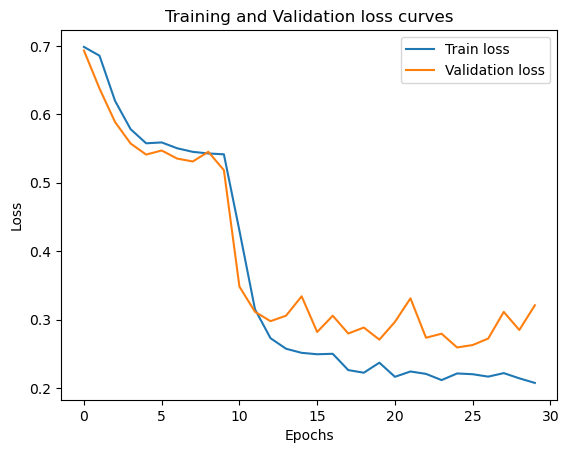

In [15]:
## - Plot loss curve
from src.vit_model import plots
plots.plot_loss(epoch_count, train_loss, val_loss)

In [19]:
from src.vit_model import predict
predict_vit = predict.predict_test(model_vit,
                                   test_dataloader,
                                   device)

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predict_vit)

array([[164,   0],
       [ 73,  91]])

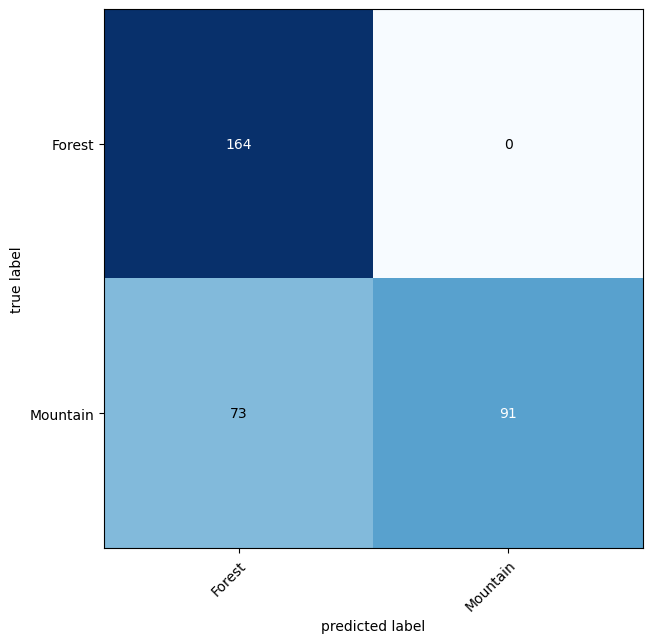

In [21]:
plots.plot_predictions_cm(class_names, y_test, predict_vit)